<div style="text-align: right;">
<a target="_blank" href="https://colab.research.google.com/github/hkaragah/hkaragah.github.io/blob/main/structure/moment_curvature/steel_w_sec_moment_curvature.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
<div style="font-size: 0.8em; color: #555;">By Hossein Karagah</div>
<div style="font-size: 0.8em; color: #555;">© Copyright 2025 GNU GENERAL PUBLIC LICENSE.</div>
</div>

# Special Concentric Braced Frame

In [1]:
from dataclasses import dataclass
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from ipywidgets import interact, FloatSlider
from math import pi, atan, cos, sin, tan, sqrt, radians, degrees
import os
import sys
sys.path.append(os.path.abspath("../../.."))
from assets.modules.shapes import AISCShape
from assets.modules.materials import ASTMSteel, SteelSectionCategories
import assets.modules.scbf as scbf

In [2]:
class Brace:
    def __init__(self, label:str, length:float, Fy: float=50, Ry: float=1.1):
        self.label = label
        self.props = AISCShape(label).props()
        self.length = length
        self.Fy = Fy
        self.Ry = Ry
    
    @property
    def A(self):
        return self.props['A']
    
    @property
    def slenderness_ratio(self):
        K = 1.0
        return K * self.length / self.props['rx']
    
    def Fcr(self, Fy: float=50):
        E = 29000
        Fe = (pi ** 2 * E) / (self.slenderness_ratio ** 2)
        if Fy/Fe <= 2.25:
            return Fy * (0.658 ** (Fy / Fe))
        else:
            return 0.877 * Fe
        
    @property
    def nominal_strength(self):
        phi = 0.9
        return phi * self.A * self.Fcr(self.Fy)
    
    @property
    def Tn(self):
        return self.A * self.Fy
    
    @property
    def Pn(self):
        Fcr = self.Fcr(self.Fy)
        return self.A * Fcr
    
    @property
    def Texp(self):
        return self.Ry * self.A * self.Fy
    
    @property
    def Cexp(self):
        Fne = self.Fcr(self.Ry * self.Fy)
        return min(self.Texp, self.A * Fne / 0.877)
    
    @property
    def Cpost(self):
        return 0.3 * self.Cexp
    
    
@dataclass
class ConnectedBrace:
    brace: Brace
    TC: str # 'T' for tension or 'C' for compression
    angle: float  # in degrees  
    
        
class Joint:
    def __init__(self, label: str, level: int, braces: list[ConnectedBrace]):
        self.label = label
        self.level = level
        self.braces = braces
        
    @property
    def Fexp(self) -> tuple:
        "Returns the resultant of expected forces in horizontal and vertical directions"
        Fx, Fy = 0, 0
        for brace in self.braces:
            if brace.TC == 'T':
                Fx += brace.brace.Texp * cos(brace.angle)
                Fy += brace.brace.Texp * sin(brace.angle)
            elif brace.TC == 'C':
                Fx -= brace.brace.Cexp * cos(brace.angle)
                Fy -= brace.brace.Cexp * sin(brace.angle)
        return Fx, Fy

    @property
    def Fpost(self) -> tuple:
        "Returns the resultant of post-buckling forces in horizontal and vertical directions"
        Fx, Fy = 0, 0
        for brace in self.braces:
            if brace.TC == 'T':
                Fx += brace.brace.Texp * cos(brace.angle)
                Fy += brace.brace.Texp * sin(brace.angle)
            elif brace.TC == 'C':
                Fx -= brace.brace.Cpost * cos(brace.angle)
                Fy -= brace.brace.Cpost * sin(brace.angle)
        return Fx, Fy


In [3]:
L = 12 * 16  # Length of braces in inches
story_height = 12 # ft
span_length = 30 # ft
THETA = atan(story_height/( 0.5 * span_length))  # radians


f1_br = {
    6: Brace('HSS6.625X0.312', L),
    5: Brace('HSS6.625X0.375', L),
    4: Brace('HSS6.625X0.312', L),
    3: Brace('HSS6.625X0.375', L),
    2: Brace('HSS6.625X0.500', L),
    1: Brace('HSS6.625X0.500', L)
}

fA_br = {
    6: Brace('HSS5.563X0.258', L),
    5: Brace('HSS5.563X0.375', L),
    4: Brace('HSS6.625X0.312', L),
    3: Brace('HSS6.625X0.375', L),
    2: Brace('HSS6.625X0.500', L),
    1: Brace('HSS6.625X0.500', L)
}

# Frame 1 Joints
j471 = Joint(label=471, level=6, 
    braces=[ConnectedBrace(f1_br[6], 'C', -THETA)])

j472 = Joint(label=472, level=6,
    braces=[ConnectedBrace(f1_br[6], 'T', pi + THETA)])

j53 = Joint(label=53, level=5,
    braces=[ConnectedBrace(f1_br[6], 'C', pi - THETA),
            ConnectedBrace(f1_br[6], 'T', THETA),
            ConnectedBrace(f1_br[5], 'C', -THETA),
            ConnectedBrace(f1_br[5], 'T', pi + THETA)])

j621 = Joint(label=621, level=4,
    braces=[ConnectedBrace(f1_br[4], 'C', -THETA)])

j615 = Joint(label=615, level=4,
    braces=[ConnectedBrace(f1_br[5], 'T', THETA),
            ConnectedBrace(f1_br[4], 'T', pi + THETA)])

j616 = Joint(label=616, level=4,
    braces=[ConnectedBrace(f1_br[5], 'C', pi - THETA),
            ConnectedBrace(f1_br[4], 'C', -THETA)])

j622 = Joint(label=622, level=4,
    braces=[ConnectedBrace(f1_br[4], 'T', pi + THETA)])

j52 = Joint(label=52, level=3,
    braces=[ConnectedBrace(f1_br[4], 'C', pi - THETA),
            ConnectedBrace(f1_br[4], 'T', THETA),
            ConnectedBrace(f1_br[3], 'C', -THETA),
            ConnectedBrace(f1_br[3], 'T', pi + THETA)])

j55 = Joint(label=55, level=3,
    braces=[ConnectedBrace(f1_br[4], 'C', pi - THETA),
            ConnectedBrace(f1_br[4], 'T', THETA),
            ConnectedBrace(f1_br[3], 'C', -THETA),
            ConnectedBrace(f1_br[3], 'T', pi + THETA)])

j765 = Joint(label=765, level=2,
    braces=[ConnectedBrace(f1_br[3], 'T', THETA),
            ConnectedBrace(f1_br[2], 'C', -THETA)])

j759 = Joint(label=759, level=2,
    braces=[ConnectedBrace(f1_br[3], 'C', pi - THETA),
            ConnectedBrace(f1_br[2], 'T', pi + THETA)])

j760 = Joint(label=760, level=2,
    braces=[ConnectedBrace(f1_br[3], 'T', THETA),
            ConnectedBrace(f1_br[2], 'C', -THETA)])

j766 = Joint(label=766, level=2,
    braces=[ConnectedBrace(f1_br[3], 'C', pi - THETA),
            ConnectedBrace(f1_br[2], 'T', pi + THETA)])

j51 = Joint(label=51, level=1,
    braces=[ConnectedBrace(f1_br[2], 'C', pi - THETA),
            ConnectedBrace(f1_br[2], 'T', THETA),
            ConnectedBrace(f1_br[1], 'C', -THETA),
            ConnectedBrace(f1_br[1], 'T', pi + THETA)])

j54 = Joint(label=54, level=1,
    braces=[ConnectedBrace(f1_br[2], 'C', pi - THETA),
            ConnectedBrace(f1_br[2], 'T', THETA),
            ConnectedBrace(f1_br[1], 'C', -THETA),
            ConnectedBrace(f1_br[1], 'T', pi + THETA)])

j446 = Joint(label=446, level=0,
    braces=[ConnectedBrace(f1_br[1], 'T', THETA)])

j440 = Joint(label=440, level=0,
    braces=[ConnectedBrace(f1_br[1], 'C', pi - THETA)])

j441 = Joint(label=441, level=0,
    braces=[ConnectedBrace(f1_br[1], 'T', THETA)])

j447 = Joint(label=447, level=0,
    braces=[ConnectedBrace(f1_br[1], 'C', pi - THETA)])

f1_joints = [j471, j472, j53, j621, j615, j616, j622, j52, j55, j765, j759, j760, j766, j51, j54, j446, j440, j441, j447]


# Frame A Joints
j465 = Joint(label=465, level=6, 
    braces=[ConnectedBrace(fA_br[6], 'C', -THETA)])

j466 = Joint(label=466, level=6,
    braces=[ConnectedBrace(fA_br[6], 'T', pi + THETA),
            ConnectedBrace(fA_br[6], 'C', -THETA)])

j467 = Joint(label=467, level=6,
    braces=[ConnectedBrace(fA_br[6], 'T', pi + THETA)])

j72 = Joint(label=72, level=5,
    braces=[ConnectedBrace(fA_br[6], 'C', pi - THETA),
            ConnectedBrace(fA_br[6], 'T', THETA),
            ConnectedBrace(fA_br[5], 'C', -THETA),
            ConnectedBrace(fA_br[5], 'T', pi + THETA)])

j69 = Joint(label=69, level=5,
    braces=[ConnectedBrace(fA_br[6], 'C', pi - THETA),
            ConnectedBrace(fA_br[6], 'T', THETA),
            ConnectedBrace(fA_br[5], 'C', -THETA),
            ConnectedBrace(fA_br[5], 'T', pi + THETA)])

j609 = Joint(label=609, level=4,
    braces=[ConnectedBrace(fA_br[5], 'T', THETA),
            ConnectedBrace(fA_br[4], 'C', -THETA)])

j610 = Joint(label=610, level=4,
    braces=[ConnectedBrace(fA_br[5], 'C', pi - THETA),
            ConnectedBrace(fA_br[5], 'T', THETA),
            ConnectedBrace(fA_br[4], 'C', -THETA),
            ConnectedBrace(fA_br[4], 'T', pi + THETA)])

j611 = Joint(label=611, level=4,
    braces=[ConnectedBrace(fA_br[5], 'C', pi - THETA),
            ConnectedBrace(fA_br[4], 'T', pi + THETA)])

j71 = Joint(label=71, level=3,
    braces=[ConnectedBrace(fA_br[4], 'C', pi - THETA),
            ConnectedBrace(fA_br[4], 'T', THETA),
            ConnectedBrace(fA_br[3], 'C', -THETA),
            ConnectedBrace(fA_br[3], 'T', pi + THETA)])

j68 = Joint(label=68, level=3,
    braces=[ConnectedBrace(fA_br[4], 'C', pi - THETA),
            ConnectedBrace(fA_br[4], 'T', THETA),
            ConnectedBrace(fA_br[3], 'C', -THETA),
            ConnectedBrace(fA_br[3], 'T', pi + THETA)])

j753 = Joint(label=753, level=2,
    braces=[ConnectedBrace(fA_br[3], 'T', THETA),
            ConnectedBrace(fA_br[2], 'C', -THETA)])

j754 = Joint(label=754, level=2,
    braces=[ConnectedBrace(fA_br[3], 'C', pi - THETA),
            ConnectedBrace(fA_br[3], 'T', THETA),
            ConnectedBrace(fA_br[2], 'C', -THETA),
            ConnectedBrace(fA_br[2], 'T', pi + THETA)])

j755 = Joint(label=755, level=2,
    braces=[ConnectedBrace(fA_br[3], 'T', pi - THETA),
            ConnectedBrace(fA_br[2], 'C', pi + THETA)])

j67 = Joint(label=67, level=1,
    braces=[ConnectedBrace(fA_br[2], 'C', pi - THETA),
            ConnectedBrace(fA_br[2], 'T', THETA),
            ConnectedBrace(fA_br[1], 'C', -THETA),
            ConnectedBrace(fA_br[1], 'T', pi + THETA)])

j70 = Joint(label=70, level=1,
    braces=[ConnectedBrace(fA_br[2], 'C', pi - THETA),
            ConnectedBrace(fA_br[2], 'T', THETA),
            ConnectedBrace(fA_br[1], 'C', -THETA),
            ConnectedBrace(fA_br[1], 'T', pi + THETA)])

j434 = Joint(label=434, level=0,
    braces=[ConnectedBrace(fA_br[1], 'T', THETA)])

j435 = Joint(label=435, level=0,
    braces=[ConnectedBrace(fA_br[1], 'C', pi - THETA),
            ConnectedBrace(fA_br[1], 'T', THETA)])

j436 = Joint(label=436, level=0,
    braces=[ConnectedBrace(fA_br[1], 'C', pi - THETA)])

fA_joints = [j465, j466, j467, j72, j69, j609, j610, j611, j71, j68, j753, j754, j755, j67, j70, j434, j435, j436]

In [4]:
F1 = pd.DataFrame({
    'Joint': [j.label for j in f1_joints],
    'Level': [j.level for j in f1_joints],
    'Fexp': [tuple(round(x, 0) for x in j.Fexp) for j in f1_joints],
    'Fpost': [tuple(round(x, 0) for x in j.Fpost) for j in f1_joints]
}).set_index('Joint')

F1

,Level,Fexp,Fpost
Joint,,,
471,6,"(-157.0, 126.0)","(-47.0, 38.0)"
472,6,"(-249.0, -199.0)","(-249.0, -199.0)"
53,5,"(-74.0, -15.0)","(-55.0, -31.0)"
621,4,"(-157.0, 126.0)","(-47.0, 38.0)"
615,4,"(47.0, 37.0)","(47.0, 37.0)"
616,4,"(28.0, -22.0)","(8.0, -7.0)"
622,4,"(-249.0, -199.0)","(-249.0, -199.0)"
52,3,"(-74.0, -15.0)","(-55.0, -31.0)"
55,3,"(-74.0, -15.0)","(-55.0, -31.0)"


In [5]:
# Frame 1 brace forces
print(f"{'Frame 1 Brace':<15}{'Texp':>10}{'Cexp':>10}{'Cpost':>10}")
print('-'*50)
for _, br in f1_br.items():
    print(f"{br.label:<15}{br.Texp:>10.0f}{br.Cexp:>10.0f}{br.Cpost:>10.0f}")
print()
# Frame A brace forces
print(f"{'Frame A Brace':<15}{'Texp':>10}{'Cexp':>10}{'Cpost':>10}")
print('-'*50)    
for _, br in fA_br.items():
    print(f"{br.label:<15}{br.Texp:>10.0f}{br.Cexp:>10.0f}{br.Cpost:>10.0f}")

Frame 1 Brace        Texp      Cexp     Cpost
--------------------------------------------------
HSS6.625X0.312        318       201        60
HSS6.625X0.375        378       236        71
HSS6.625X0.312        318       201        60
HSS6.625X0.375        378       236        71
HSS6.625X0.500        495       302        91
HSS6.625X0.500        495       302        91

Frame A Brace        Texp      Cexp     Cpost
--------------------------------------------------
HSS5.563X0.258        221       109        33
HSS5.563X0.375        315       151        45
HSS6.625X0.312        318       201        60
HSS6.625X0.375        378       236        71
HSS6.625X0.500        495       302        91
HSS6.625X0.500        495       302        91


In [6]:
FA = pd.DataFrame({
    'Joint': [j.label for j in fA_joints],
    'Level': [j.level for j in fA_joints],
    'Fexp': [tuple(round(x, 0) for x in j.Fexp) for j in fA_joints],
    'Fpost': [tuple(round(x, 0) for x in j.Fpost) for j in fA_joints]
}).set_index('Joint')

FA

,Level,Fexp,Fpost
Joint,,,
465,6,"(-85.0, 68.0)","(-25.0, 20.0)"
466,6,"(-257.0, -70.0)","(-198.0, -117.0)"
467,6,"(-172.0, -138.0)","(-172.0, -138.0)"
72,5,"(-106.0, -32.0)","(-83.0, -51.0)"
69,5,"(-106.0, -32.0)","(-83.0, -51.0)"
609,4,"(89.0, 322.0)","(199.0, 234.0)"
610,4,"(-42.0, 29.0)","(-15.0, 7.0)"
611,4,"(-131.0, -293.0)","(-213.0, -227.0)"
71,3,"(-74.0, -15.0)","(-55.0, -31.0)"


In [7]:
# AISC 341-22 Manual Example 5.3.2
Lb = 12*12 # inches

# Use ASTM A500 Grade C for brace material
Fy = 50
Ry = 1.3

br4 = Brace('HSS6.000X0.312', Lb, Fy, Ry)
br3 = Brace('HSS7.000X0.500', Lb, Fy, Ry)
br2 = Brace('HSS7.500X0.500', Lb, Fy, Ry)
br1 = Brace('HSS8.625X0.500', Lb, Fy, Ry)

braces = [br4, br3, br2, br1]

for br in braces:
    print(f"{br.label}({br.A}): Texp = {br.Texp:.0f}, Cexp = {br.Cexp:.0f}, Cpost = {br.Cpost:.0f}")

HSS6.000X0.312(5.22): Texp = 339, Cexp = 239, Cpost = 72
HSS7.000X0.500(9.55): Texp = 621, Cexp = 491, Cpost = 147
HSS7.500X0.500(10.3): Texp = 670, Cexp = 556, Cpost = 167
HSS8.625X0.500(11.9): Texp = 774, Cexp = 697, Cpost = 209


In [8]:
@dataclass
class BraceForce:
    P: float  # Axial force in brace (+ tension, - compression)
    theta: float  # Angle of brace with respect to horizontal (degrees)
    
@dataclass
class GussetDimensions:
    h: float  # Vertical height of gusset
    Lg: float  # Horizontal length of gusset
       
    
def get_gusset_beam_forces(Bl: BraceForce, Br: BraceForce, delta: float, eb: float) -> tuple:
    """Returns the forces acting on the gusset-to-beam interface given the bracing forces acting exerted to the gusset.

    Args:
        Bl (BraceForce): Left brace force and angle
        Br (BraceForce): Right brace force and angle
        delta (float): Horizontal distance between working point (w.p.) to middle of beam-to-gusset interface.
        eb (float): Vertical distance between w.p. to top of beam-to-gusset interface.

    Returns:
        tuple: Forces acting on the gusset-to-beam interface (horizontal, vertical, moment). Upward and rightward positive. Counter-clockwise moment positive.
    """
    
    Hl = -Bl.P * cos(radians(Bl.theta))
    Vl = -Bl.P * sin(radians(Bl.theta))
    Hr = Br.P * cos(radians(Br.theta))
    Vr = -Br.P * sin(radians(Br.theta))
    
    Ha = -(Hl + Hr)
    Va = -(Vl + Vr)
    Ma = (Vl + Vr) * delta - (Hl + Hr) * eb
    
    return Ha, Va, Ma


def get_half_gusset_forces(Bl: BraceForce, Br: BraceForce, G: GussetDimensions,delta:float, eb: float) -> tuple:
    
    Hl = -Bl.P * cos(radians(Bl.theta))
    Vl = -Bl.P * sin(radians(Bl.theta))
    Hr = Br.P * cos(radians(Br.theta))
    Vr = -Br.P * sin(radians(Br.theta))
    
    _, _, Ma = get_gusset_beam_forces(Bl, Br, delta, eb)
    
    Hbl = (Hl + Hr) / 2 - Hl
    Vbl = (Vl + Vr) / 2 - 2 * Ma / G.Lg - Vl
    Mbl = G.Lg * (Vl + Vr) / 8 + G.h * (Hl + Hr) / 4 - Ma / 2 + Vl * delta - Hl * (eb + G.h / 2)
        
    Hbr = (Hl + Hr) / 2 - Hr
    Vbr = (Vl + Vr) / 2 + 2 * Ma / G.Lg - Vr
    Mbr = -G.Lg * (Vl + Vr) / 8 + G.h * (Hl + Hr) / 4 - Ma / 2 + Vr * delta - Hr * (eb + G.h / 2)
    
    return (Hbl, Vbl, Mbl), (Hbr, Vbr, Mbr)



    

In [9]:
# W18X143 Beam
beam = AISCShape('W18X143')
eb = beam.props()['d'] / 2
delta = 9.25

# Left brace force (tension)
brace_l = BraceForce(P=407, theta=degrees(atan(8/12)))  

# Right brace force (compression)
brace_r = BraceForce(P=-222, theta=degrees(atan(11/12)))

# Gusset plate dimensions
gusset = GussetDimensions(h=1*12+10+3/4, Lg=5*12+10+5/8)

Ha, Va, Ma = get_gusset_beam_forces(brace_l, brace_r, delta, eb)
print("\nGusset-to-beam interface forces:")
print(f"  H_aa: {Ha:.1f} kips")
print(f"  V_aa: {Va:.1f} kips")
print(f"  M_aa: {Ma:.1f} kip-in")

Fl, Fr = get_half_gusset_forces(brace_l, brace_r, gusset, delta, eb)
print("\nLeft half-gusset forces:")
print(f"  H_bl: {Fl[0]:.1f} kips")
print(f"  V_bl: {Fl[1]:.1f} kips")
print(f"  M_bl: {Fl[2]:.1f} kip-in")
print("\nRight half-gusset forces:")
print(f"  H_br: {Fr[0]:.1f} kips")
print(f"  V_br: {Fr[1]:.1f} kips")
print(f"  M_br: {Fr[2]:.1f} kip-in")



Gusset-to-beam interface forces:
  H_aa: 502.3 kips
  V_aa: 75.8 kips
  M_aa: 4196.6 kip-in

Left half-gusset forces:
  H_bl: 87.5 kips
  V_bl: 69.0 kips
  M_bl: -558.3 kip-in

Right half-gusset forces:
  H_br: -87.5 kips
  V_br: -69.0 kips
  M_br: 558.3 kip-in


In [10]:
# Brace (Square HSS9x9x5/8)
br_hss9x9x58 = Brace('HSS9X9X5/8', length=22*12, Fy=50, Ry=1.3)

print(f"phi*Tn: {0.9*br_hss9x9x58.Tn:.0f} kips") 
print(f"phi*Pn: {0.9*br_hss9x9x58.Pn:.0f} kips")
print(f"Texp: {br_hss9x9x58.Texp:.0f} kips")
print(f"Cexp: {br_hss9x9x58.Cexp:.0f} kips")
print(f"Cpost: {br_hss9x9x58.Cpost:.0f} kips")


# Beam (W21x83)
bm_w21x83 = AISCShape('W21X83')
eb = bm_w21x83.props()['d'] / 2
delta = ((1*12+8.5) - (2*12+3.25)) / 2 # inches, negative since w.p. is on the left half of the beam


# Brace forces
theta_L, theta_R = degrees(atan(12/9)), degrees(atan((10+11/16)/12))

# Left brace force (tension)
br_L1 = BraceForce(P=449, theta=theta_L)  # kips
br_L2 = BraceForce(P=1205, theta=theta_L)  # kips
br_L3 = BraceForce(P=1205, theta=theta_L)  # kips

# Right brace force (compression)
br_R1 = BraceForce(P=-540, theta=theta_R)  # kips
br_R2 = BraceForce(P=-778, theta=theta_R)  # kips
br_R3 = BraceForce(P=-233, theta=theta_R)  # kips

br_forces = {
    'case1': (br_L1, br_R1),
    'case2': (br_L2, br_R2),
    'case3': (br_L3, br_R3)
}

# Gusset plate dimensions
gusset = GussetDimensions(h=9.125, Lg=3*12+11.75)

gusset_forces = {}
for case, (brace_L, brace_R) in br_forces.items():
    Ha1, Va1, Ma1 = get_gusset_beam_forces(brace_L, brace_R, delta, eb)
    gusset_forces[case] = (Ha1, Va1, Ma1)
    
    print(f"\nGusset-to-beam interface forces for {case}:")
    print(f"  H_aa: {Ha1:.1f} kips")
    print(f"  V_aa: {Va1:.1f} kips")
    print(f"  M_aa: {Ma1:.1f} kips-in")


phi*Tn: 842 kips
phi*Pn: 542 kips
Texp: 1216 kips
Cexp: 781 kips
Cpost: 234 kips

Gusset-to-beam interface forces for case1:
  H_aa: 672.7 kips
  V_aa: 0.1 kips
  M_aa: 7197.6 kips-in

Gusset-to-beam interface forces for case2:
  H_aa: 1304.0 kips
  V_aa: 446.6 kips
  M_aa: 15459.8 kips-in

Gusset-to-beam interface forces for case3:
  H_aa: 897.0 kips
  V_aa: 809.0 kips
  M_aa: 12328.4 kips-in


## Example
### Define Materials

In [11]:
A36 = ASTMSteel('A36', cat=SteelSectionCategories.PLATES, fy=36)
A992 = ASTMSteel('A992', cat=SteelSectionCategories.HOT_ROLLED, fy=50)
A500GRC = ASTMSteel('A500 Gr B', cat=SteelSectionCategories.HOLLOW_STRUCTURAL_SECTIONS, fy=50)

### Define Beam, Braces, and Gusset

In [12]:

Lb = 28 # beam span (ft)
Hs = 14 # story height (ft)
Lbr = sqrt((0.5*Lb)**2 + (Hs)**2)  # ft

bm_w21x93 = AISCShape('W21X93')
br_hss5x5x500 = scbf.Brace('HSS5X5X1/2', length=12*Lbr, mat=A500GRC)
br_hss4x4x375 = scbf.Brace('HSS4X4X3/8', length=12*Lbr, mat=A500GRC)

eb = 0.375*Lb # inches # beam.props()['d'] / 2
Lg = 56 # inches
Delta_t = 0 # inches
Delta_b = 0 # inches

top_gusset = scbf.GussetPlate(Lg, h=10, loc=(Delta_t, eb))
bottom_gusset = scbf.GussetPlate(Lg, h=10, loc=(Delta_b, -eb))
gussets = {
    'top': top_gusset,
    'bottom': bottom_gusset
}

Xwp = Lb / 2 # ft

### Define Brace Forces

In [13]:
# Define brace forces
brace_forces = {
    'case1': { # Expected
        'top': {
            'left': scbf.Force(-94.8, degrees(pi - atan(12/12))),
            'right': scbf.Force(308, degrees(atan(12/12)))
            },
        'bottom': {
            'left': scbf.Force(507, degrees(pi + atan(12/12))),
            'right': scbf.Force(-243, degrees(-atan(12/12)))
            }
        },
    'case2': { # Post-buckling
        'top': {
            'left': scbf.Force(-28.4, degrees(pi - atan(12/12))),
            'right': scbf.Force(308, degrees(atan(12/12)))
            },
        'bottom': {
            'left': scbf.Force(507, degrees(pi + atan(12/12))),
            'right': scbf.Force(-72.9, degrees(-atan(12/12)))
            }
        }
    }

### Total Forces Applied to Beam

In [14]:
for case in brace_forces.keys():
    print(f"\n=== {case} ===")
    
    HT1, VT1 = scbf.sum_horizontal_and_vertical_forces(brace_forces[case])
    print(f" sum_HT: {HT1['top'] + HT1['bottom']:.0f} kips")
    print(f" sum_VT: {VT1['top'] + VT1['bottom']:.0f} kips")
    
    Pa1 = scbf.chevron_gusset_forces_at_beam_interface(gussets, brace_forces[case])
    Ma_t = Pa1['top'][2]
    Ma_b = Pa1['bottom'][2]
    MT = Ma_t + Ma_b
    print(f" M_T: {MT:.0f} kip-in")



=== case1 ===
 sum_HT: -246 kips
 sum_VT: -36 kips
 M_T: 8559 kip-in

=== case2 ===
 sum_HT: -172 kips
 sum_VT: -109 kips
 M_T: 6803 kip-in


### Equivalent Uniform Loads Applied to Beam

In [15]:
for case in brace_forces.keys():
    q = scbf.uniform_moment_due2_horizontal_force(gussets, brace_forces[case])
    w = scbf.uniform_load_due2_vertical_force_and_moment(gussets, brace_forces[case])

    print(f"{f'Gusset ({case})':<10}{'q (kip-in/in)':>20}{'wl (kip/in)':>20}{'wr (kip/in)':>20}")
    print('-'*75)
    
    qt, wlt, wrt = 0, 0, 0
    
    for key in gussets.keys():
        print(f"{key:<10}{q[key]:>20.0f}{w[key]['left']:>20.1f}{w[key]['right']:>20.1f}")
        
        qt += q[key]
        wlt += w[key]['left']
        wrt += w[key]['right']
        
    print(f"{'Total':<10}{qt:>20.0f}{wlt:>20.1f}{wrt:>20.1f}\n")

Gusset (case1)       q (kip-in/in)         wl (kip/in)         wr (kip/in)
---------------------------------------------------------------------------
top                         53                -1.1                 6.5
bottom                      99               -10.4                 3.8
Total                      153               -11.6                10.3

Gusset (case2)       q (kip-in/in)         wl (kip/in)         wr (kip/in)
---------------------------------------------------------------------------
top                         45                 0.3                 6.7
bottom                      77               -11.0                 0.0
Total                      121               -10.6                 6.7



### Beam Reactions

In [16]:
for case in brace_forces.keys():
    print(f"\n=== Beam reactions for {case} ===")
    
    Rl, Rr = scbf.beam_reactions_due2_chevron_effect(12*Lb, 12*Xwp, gussets, brace_forces[case])
    print(f" Rl: {Rl:.1f} kip")
    print(f" Rr: {Rr:.1f} kip")


=== Beam reactions for case1 ===
 Rl: 18.0 kip
 Rr: 18.0 kip

=== Beam reactions for case2 ===
 Rl: 54.6 kip
 Rr: 54.6 kip


### Beam Internal Shear and Moment

In [17]:
nPoints = 1000
x = np.linspace(0, 12*Lb, nPoints)

V, M = {}, {}

for case in brace_forces.keys():
    V[case] = scbf.beam_internal_shear_due2_chevron_effect(x, 12*Xwp, gussets, brace_forces[case])
    M[case] = scbf.beam_internal_moment_due_to_chevron_effect(x, 12*Xwp, gussets, brace_forces[case])


### Beam Shear and Moment Diagrams

In [18]:
def get_max(x: np.ndarray, y: np.ndarray):
    idx = np.argmax(np.abs(y))
    xm = x[idx]
    ym = y[idx]
    
    return idx, xm, ym
    
    
def plot_data(ax: Axes, x: np.ndarray, y: np.ndarray, fill: bool = False,**kwargs):
    label = kwargs.get('label')
    title = kwargs.get('title')
    xlabel = kwargs.get('xlabel')
    ylabel = kwargs.get('ylabel')
    linewidth = kwargs.get('linewidth', 1)
    
    ax.plot(x, y, color='black', linewidth=linewidth, label=label)
    ax.axhline(0, color='gray', linewidth=0.5)
    
    if fill:
        ax.fill_between(x, y, where=(y >= 0), color='lightblue', alpha=0.3)
        ax.fill_between(x, y, where=(y <= 0), color='lightcoral', alpha=0.3)

    _, _, ym = get_max(x, y)

    ax.set_xlim(0, np.max(x))
    ax.set_ylim(-abs(ym)*1.1, abs(ym)*1.1)
    
    if title:    
        ax.set_title(title)
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)
    if label:
        ax.legend()
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    
def annotate(ax: Axes, x: float, y: float, text: str, **kwargs):
    fontsize = kwargs.get('fontsize', 9)
    xytext = kwargs.get('xytext', (10, 10))
    textcoords = kwargs.get('textcoords', 'offset points')
    arrowprops = kwargs.get('arrowprops', dict(arrowstyle='->', color='red'))
    
    ax.annotate(text, xy=(x, y), xytext=xytext, textcoords=textcoords,
                fontsize=fontsize, arrowprops=arrowprops)

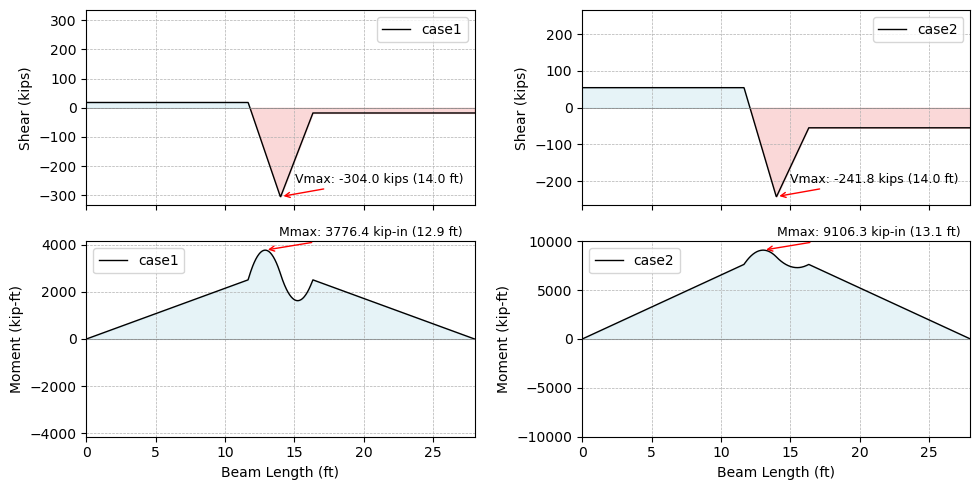

In [19]:
x_ft = x / 12  # convert to feet

fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(10, 5), sharex=True)

for i, case in enumerate(brace_forces.keys()):
    
    # shear diagram
    plot_data(ax[0, i], x_ft, V[case], fill=True, label = f"{case}", ylabel='Shear (kips)')
    _, xm, Vm = get_max(x_ft, V[case])
    annotate(ax[0, i], xm, Vm, f"Vmax: {Vm:.1f} kips ({xm:.1f} ft)")
    
    # moment diagram
    plot_data(ax[1, i], x_ft, M[case], fill=True, label = f"{case}", xlabel='Beam Length (ft)', ylabel='Moment (kip-ft)')
    _, xm, Mm = get_max(x_ft, M[case])
    annotate(ax[1, i], xm, Mm, f"Mmax: {Mm:.1f} kip-in ({xm:.1f} ft)")

plt.tight_layout()
plt.show()

### Putting it together

In [20]:
def define_braces(top: dict, bot: dict, Lb: float, Xwp: float, Hs: float):
    br_tl, br_tr = top.get('left'), top.get('right')
    br_bl, br_br = bot.get('left'), bot.get('right')

    braces = {}
    if br_tl:
        Lbr_tl = sqrt(Xwp**2 + Hs**2) # inches
        braces['top']['left'] = scbf.Brace(br_tl, length=Lbr_tl, mat=A500GRC)
        
    if br_tr:
        Lbr_tr = sqrt((Lb - Xwp)**2 + Hs**2) # inches
        braces['top']['right'] = scbf.Brace(br_tr, length=Lbr_tr, mat=A500GRC)

    if br_bl:
        Lbr_bl = sqrt(Xwp**2 + Hs**2) # inches
        braces['bottom']['left'] = scbf.Brace(br_bl, length=Lbr_bl, mat=A500GRC)

    if br_br:
        Lbr_br = sqrt((Lb - Xwp)**2 + Hs**2) # inches
        braces['bottom']['right'] = scbf.Brace(br_br, length=Lbr_br, mat=A500GRC)

    return braces


# Define gusset plates
def define_gussets(top: dict, bot:dict):
    Lg_t, h_t, loc_t = top.get('Lg'), top.get('h'), top.get('loc')
    Lg_b, h_b, loc_b = bot.get('Lg'), bot.get('h'), bot.get('loc')

    if Lg_t and h_t and loc_t:
        top_gusset = scbf.GussetPlate(Lg_t, h=h_t, loc=loc_t)
    else:
        top_gusset = None
    
    if Lg_b and h_b and loc_b:
        bottom_gusset = scbf.GussetPlate(Lg_b, h=h_b, loc=loc_b)
    else:
        bottom_gusset = None

    return {'top': top_gusset, 'bottom': bottom_gusset}


# Define brace forces
def define_brace_forces(top: dict, bot:dict, Lb:float, Xwp:float, Hs:float):
    PCt, PTt, DPt = top.get('Pc'), top.get('Pt'), top.get('DP')
    PCb, PTb, DPb = bot.get('Pc'), bot.get('Pt'), bot.get('DP')

    # Top left and right brace angles
    theta_lt = pi - atan(Hs / Xwp)
    theta_rt = atan(Hs/(Lb - Xwp))
    
    # Bottom left and right brace angles
    theta_lb = pi + atan(Hs / (Xwp))
    theta_rb = -atan(Hs / (Lb - Xwp))
                
    if PCt is None or (PTt is None and DPt is None):
        PCt, PTt = 0, 0
    elif PTt is None and DPt is not None:
        PTt = PCt * sin(degrees(theta_lt)) / sin(degrees(theta_rt))
        
    if PCb is None or (PTb is None and DPb is None):
        PCb, PTb = 0, 0
    elif PTb is None and DPb is not None:
        PTb = PCb * sin(degrees(theta_rb)) / sin(degrees(theta_lb))

    forces = {
        'top': {
            'left': scbf.Force(PCt, degrees(theta_lt)), # compression
            'right': scbf.Force(PTt, degrees(theta_rt)) # tension
            },
        'bottom': {
            'left': scbf.Force(PTb, degrees(theta_lb)), # tension
            'right': scbf.Force(PCb, degrees(theta_rb)) # compression
            }
    }

    return forces

In [21]:
# Compute total forces applied to beam
def get_total_gusset_forces_on_beam(gussets: dict, brace_forces: dict):
    HT1, VT1 = scbf.sum_horizontal_and_vertical_forces(brace_forces)
    
    print(f" sum_HT: {HT1['top'] + HT1['bottom']:.0f} kips")
    print(f" sum_VT: {VT1['top'] + VT1['bottom']:.0f} kips")
    
    Pa1 = scbf.chevron_gusset_forces_at_beam_interface(gussets, brace_forces)
    Ma_t = Pa1['top'][2]
    Ma_b = Pa1['bottom'][2]
    MT = Ma_t + Ma_b
    
    print(f" M_T: {MT:.0f} kip-in")
    
    
# compute uniform loads applied to beam
def get_uniform_loads_on_beam(gussets: dict, brace_forces: dict):
    q = scbf.uniform_moment_due2_horizontal_force(gussets, brace_forces)
    w = scbf.uniform_load_due2_vertical_force_and_moment(gussets, brace_forces)

    print(f"\n{f'Gusset':<10}{'q (kip-in/in)':>20}{'wl (kip/in)':>20}{'wr (kip/in)':>20}")
    print('-'*75)
    
    qt, wlt, wrt = 0, 0, 0
    
    for key in gussets.keys():
        print(f"{key:<10}{q[key]:>20.0f}{w[key]['left']:>20.1f}{w[key]['right']:>20.1f}")
        
        qt += q[key]
        wlt += w[key]['left']
        wrt += w[key]['right']
        
    print(f"{'Total':<10}{qt:>20.0f}{wlt:>20.1f}{wrt:>20.1f}")
    
    
# Compute beam reactions
def get_beam_reactions_due2_chevron_effect(Lb: float, Xwp: float, gussets: dict, brace_forces: dict):    
    Rl, Rr = scbf.beam_reactions_due2_chevron_effect(Lb, Xwp, gussets, brace_forces)
    
    print(f"\nBeam reactions:")
    print(f" Rl: {Rl:.1f} kip")
    print(f" Rr: {Rr:.1f} kip")
    
    
# Generate beam shear and moment values
def get_shear_moment(Lb, Xwp: float, gussets: dict, brace_forces: dict, nPoints: int = 1000):
    x = np.linspace(0, Lb, nPoints)

    V = scbf.beam_internal_shear_due2_chevron_effect(x, Xwp, gussets, brace_forces)
    M = scbf.beam_internal_moment_due_to_chevron_effect(x, Xwp, gussets, brace_forces)
    
    return x, V, M
    

# Plot beam shear and moment diagrams
def plot_shear_moment_diagrams(x: np.ndarray, V: np.ndarray, M: np.ndarray):
    x_ft = x / 12  # convert to feet
    
    fig, ax = plt.subplots(nrows=2, ncols=1,figsize=(10, 4), sharex=True)

    plot_data(ax[0], x_ft, V, fill=True, ylabel='Shear (kips)')
    plot_data(ax[1], x_ft, M, fill=True, xlabel='Beam Length (ft)', ylabel='Moment (kip-in)')
    
    _, xm, Vm = get_max(x_ft, V)
    annotate(ax[0], xm, Vm, f"{Vm:.1f}@{xm:.1f}")
    
    _, xm, Mm = get_max(x_ft, M)
    annotate(ax[1], xm, Mm, f"{Mm:.1f}@{xm:.1f}")
    
    plt.tight_layout()
    plt.show()



 sum_HT: -25 kips
 sum_VT: -112 kips
 M_T: 9190 kip-in

Gusset           q (kip-in/in)         wl (kip/in)         wr (kip/in)
---------------------------------------------------------------------------
top                         83                -4.7                 7.9
bottom                      87                -8.5                 1.5
Total                      170               -13.3                 9.3

Beam reactions:
 Rl: 66.6 kip
 Rr: 45.5 kip


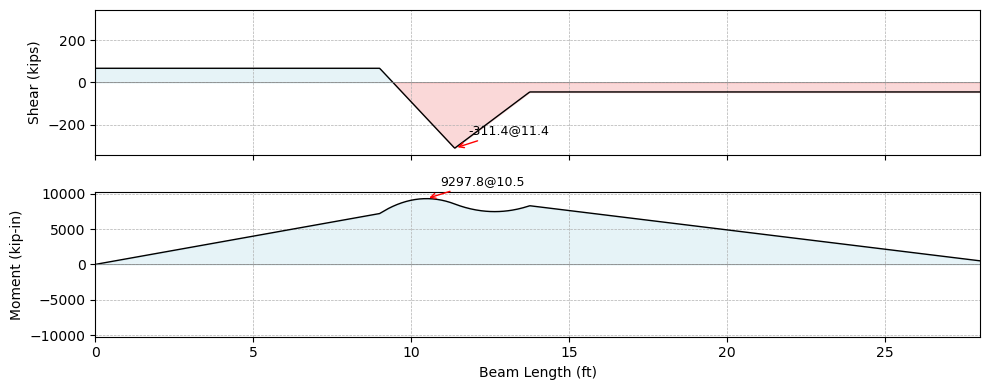

In [27]:
Lb = 28*12 # beam span (in)
Hs = 14*12 # story height (in)
Xwp = 11*12 # (in)

eb = 10.75 # 0.375*(Lb/12) # inches
Delta_t = 4.5 # inches
Delta_b = 4.5 # inches

bm = AISCShape('W21X93') # Beam section

GUSS = define_gussets(
    {'Lg': 57, 'h': 10, 'loc': (Delta_t, eb)},
    {'Lg': 57, 'h': 10, 'loc': (Delta_b, -eb)}
    )

# F_br = define_brace_forces(
#     {'Pc': -28.4, 'Pt': 308}, # top brace forces
#     {'Pc': -72.9, 'Pt': 507}, # bottom brace forces
#     Lb, Xwp, Hs
#     )

F_br = define_brace_forces(
    {'Pc': -210, 'Pt': 400}, # top brace forces
    {'Pc': -240, 'Pt': 450}, # bottom brace forces
    Lb, Xwp, Hs
    )

# F_br = define_brace_forces(
#     {'Pc': 0, 'Pt': 0}, # top brace forces
#     {'Pc': -400, 'Pt': 500}, # bottom brace forces
#     Lb, Xwp, Hs
#     )

get_total_gusset_forces_on_beam(GUSS, F_br)
get_uniform_loads_on_beam(GUSS, F_br)
get_beam_reactions_due2_chevron_effect(Lb, Xwp, GUSS, F_br)
get_shear_moment(Lb, Xwp, GUSS, F_br)
x, V, M = get_shear_moment(Lb, Xwp, GUSS, F_br)
plot_shear_moment_diagrams(x, V, M)

### Interactive Diagram

In [23]:
Lb = 28*12 # beam span (in)
Hs = 14*12 # story height (in)
Xwp = Lb / 2 # (in)

h = 10 # inches
Lg_t = 56 # inches
Lg_b = 56 # inches
eb_t = 0.375*(Lb/12) # inches
eb_b = 0.375*(Lb/12) # inches
Delta_t = 0 # inches
Delta_b = 0 # inches

PC_t, DP_t = 0, 0
PC_b, DP_b = -200, 0 

def int_plot(
    Lb=Lb, Xwp=Xwp, Hs=Hs,
    Lg_t=Lg_t, h_t=h, loc_t=(Delta_t, eb_t),
    Lg_b=Lg_b, h_b=h, loc_b=(Delta_b, eb_b),
    PC_t=PC_t, DP_t=DP_t,
    PC_b=PC_b, DP_b=DP_b,
    ):
    
    gussets = define_gussets(
        top={'Lg': Lg_t, 'h': h_t, 'loc': loc_t},
        bot={'Lg': Lg_b, 'h': h_b, 'loc': loc_b}
        )
    print(gussets)
    forces = define_brace_forces(
        top={'Pc': PC_t, 'DP': DP_t},
        bot={'Pc': PC_b, 'DP': DP_b},
        Lb=Lb, Xwp=Xwp, Hs=Hs
        )
    print(forces)
    x, V, M = get_shear_moment(Lb, Xwp, gussets, forces)
    x_ft = x / 12  # convert to feet
    
    fig, ax = plt.subplots(nrows=2, ncols=1,figsize=(8, 6), sharex=True)
    plot_data(ax[0], x_ft, V, fill=True, ylabel='Shear (kips)')
    plot_data(ax[1], x_ft, M, fill=True, xlabel='Beam Length (ft)', ylabel='Moment (kip-in)')
    
    plt.tight_layout()
    plt.show()



In [24]:
interact(
    int_plot,
    Xwp=FloatSlider(value=Lb/2, min=1, max=Lb, step=0.25, description="Xwp"),
    # Lg=FloatSlider(value=12*Lb/6, min=10, max=80, step=0.5, description="Lg"),
    # eb=FloatSlider(value=0.375*Lb, min=0.1*Lb, max=0.5*Lb, step=0.05, description="eb"),
    # DPt=FloatSlider(value=400, min=0, max=800, step=10, description="ΔPt"),
    # DPb=FloatSlider(value=300, min=0, max=800, step=10, description="ΔPb"),
    # Delta_t=FloatSlider(value=0, min=-5, max=5, step=0.25, description="Δt"),
    # Delta_b=FloatSlider(value=0, min=-5, max=5, step=0.25, description="Δb")
)

interactive(children=(IntSlider(value=336, description='Lb', max=1008, min=-336), FloatSlider(value=168.0, des…

<function __main__.int_plot(Lb=336, Xwp=168.0, Hs=168, Lg_t=56, h_t=10, loc_t=(0, 10.5), Lg_b=56, h_b=10, loc_b=(0, 10.5), PC_t=0, DP_t=0, PC_b=-200, DP_b=0)>